================================================================================

**Author**: Meir Moshkovitz

**Subject**:

**Regression based predictions of house pricing in King County, Washington, USA, based on house sales dataset (May 2014 - May 2015)**

[Data source appears in Kaggle.com]

**Date**:March 2020

**Course**: Data Science.

Submitted as final project in the Regression part of the course.

================================================================================

**Disclaimer**:

This notebook and software was designed to be used only for private learning purposes.

Any use or copying of this software or part of it, is not allowed.

This notebook and software comes with no warranties of any kind whatsoever.

================================================================================

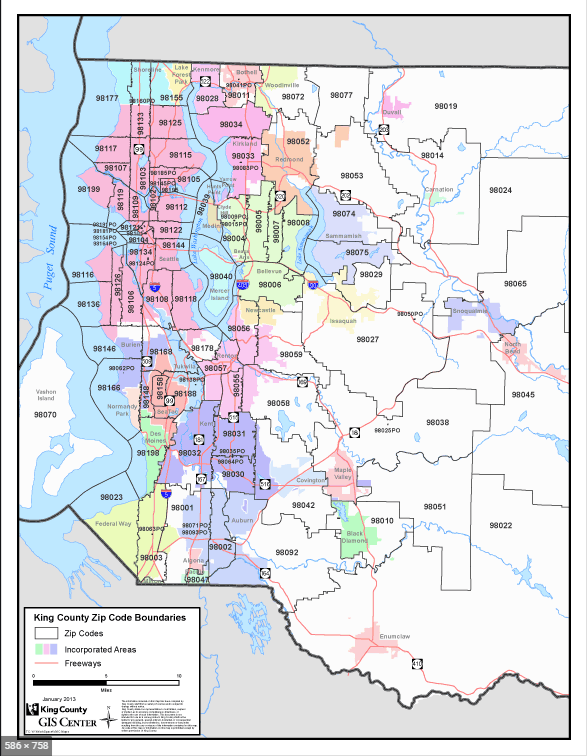

In [0]:
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

# For the tree visualization
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse


# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

# Purpose

Prediction of the price of houses based on the common methods of Regression:
* Linear Regression
* Decision tree
* K nearest neighbours regression


## Reading the data

In [347]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving kc_house_data.csv to kc_house_data (1).csv


In [348]:
import datetime as dt

kc_house_data = pd.read_csv('kc_house_data.csv', parse_dates=['date'])

kc_house_data


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


## Feature Engineering:

In [349]:
#Temporary columns:
kc_house_data['yr_sold'] = kc_house_data['date'].apply(lambda x: x.year)

# year built to be replaced by house age which is more significant
kc_house_data['house_age'] =  kc_house_data['yr_sold'] -  kc_house_data['yr_built']

# sale date (year) to be replaced by days count from a close reference point (2014 start)
# which may be more sensitive to period trends during the sample period.
kc_house_data['sale_day_since_2014'] = (kc_house_data['date'] - dt.datetime(2014, 1, 1)).dt.days

# Assumption: renovation factor decrease linearly with years post renovation and vanished after 20 years
kc_house_data['renovation_factor'] =  20 - (kc_house_data['yr_sold'] - kc_house_data['yr_renovated'])
kc_house_data.loc[kc_house_data['renovation_factor'] < 0, 'renovation_factor'] = 0

# Assuming that 'sqft_living15', 'sqft_lot15' describes the respective areas of the 15 nearest neighbouring houses, I've decided not to include them in the analysis
# in order to reduce the dataset dimentions presuming their influence on pricing is only secondary. 

# zipcode has been omotted from the analysis because it is essentially a geographic positional data,
# which is alreadr precisly captured by the lattidude-longitude coordinates.
kc_house_data = kc_house_data.drop(['date', 'id', 'zipcode', 'yr_renovated', 'yr_sold', 'yr_built', 'sqft_living15', 'sqft_lot15'], axis =1, inplace = False)

kc_house_data



,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,house_age,sale_day_since_2014,renovation_factor
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,47.5112,-122.257,59,285,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,47.7210,-122.319,63,342,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,47.7379,-122.233,82,420,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,47.5208,-122.393,49,342,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,47.6168,-122.045,28,413,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,47.6993,-122.346,5,140,0
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,47.5107,-122.362,1,418,0
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,47.5944,-122.299,5,173,0
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,47.5345,-122.069,11,380,0


In [0]:
#kc_house_data.groupby('waterfront').count()  # 0 - 1
#kc_house_data.groupby('view').count()        # 0 - 4
#kc_house_data.groupby('condition').count()   # 1 - 5
#kc_house_data.groupby('grade').count()       # 1 - 13
#kc_house_data.groupby('renovation_factor').mean()       # 0 - 21

# Preprocessing:

In [350]:
kc_house_data.shape

(21613, 17)

In [351]:
kc_house_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 17 columns):
price                  21613 non-null float64
bedrooms               21613 non-null int64
bathrooms              21613 non-null float64
sqft_living            21613 non-null int64
sqft_lot               21613 non-null int64
floors                 21613 non-null float64
waterfront             21613 non-null int64
view                   21613 non-null int64
condition              21613 non-null int64
grade                  21613 non-null int64
sqft_above             21613 non-null int64
sqft_basement          21613 non-null int64
lat                    21613 non-null float64
long                   21613 non-null float64
house_age              21613 non-null int64
sale_day_since_2014    21613 non-null int64
renovation_factor      21613 non-null int64
dtypes: float64(5), int64(12)
memory usage: 2.8 MB


## Cleaning

### Dropping rows with, possibly,  negative values

In [0]:
def drop_negative_bedrooms(df):
    return df.loc[(df.bedrooms >=0)]

In [0]:
negative_bedrooms_dropper = FunctionTransformer(drop_negative_bedrooms, validate=False)

In [0]:
c = negative_bedrooms_dropper.fit_transform(kc_house_data)

In [355]:
len(kc_house_data.index)

21613

### Dropping possible erroneous area related rows:

In [0]:
def drop_erroneous_sqft_rows(df):
    return df.loc[(df.sqft_living > df.sqft_lot)]    

In [0]:
erroneous_sqft_rows_dropper = FunctionTransformer(drop_erroneous_sqft_rows, validate=False)

In [0]:
d = erroneous_sqft_rows_dropper.fit_transform(kc_house_data)

In [359]:
len(kc_house_data.index)

21613

### Scanning for null possible values:

In [360]:
kc_house_data.head(10)
#kc_house_data.plot.scatter('sqft_lot', 'sqft_lot15')

kc_house_data.isnull().any()

price                  False
bedrooms               False
bathrooms              False
sqft_living            False
sqft_lot               False
floors                 False
waterfront             False
view                   False
condition              False
grade                  False
sqft_above             False
sqft_basement          False
lat                    False
long                   False
house_age              False
sale_day_since_2014    False
renovation_factor      False
dtype: bool

### Scanning for possible n/a values:

In [361]:
kc_house_data.isna().any()

price                  False
bedrooms               False
bathrooms              False
sqft_living            False
sqft_lot               False
floors                 False
waterfront             False
view                   False
condition              False
grade                  False
sqft_above             False
sqft_basement          False
lat                    False
long                   False
house_age              False
sale_day_since_2014    False
renovation_factor      False
dtype: bool

In [362]:
kc_house_data.shape

(21613, 17)

### Enquiring price distribution

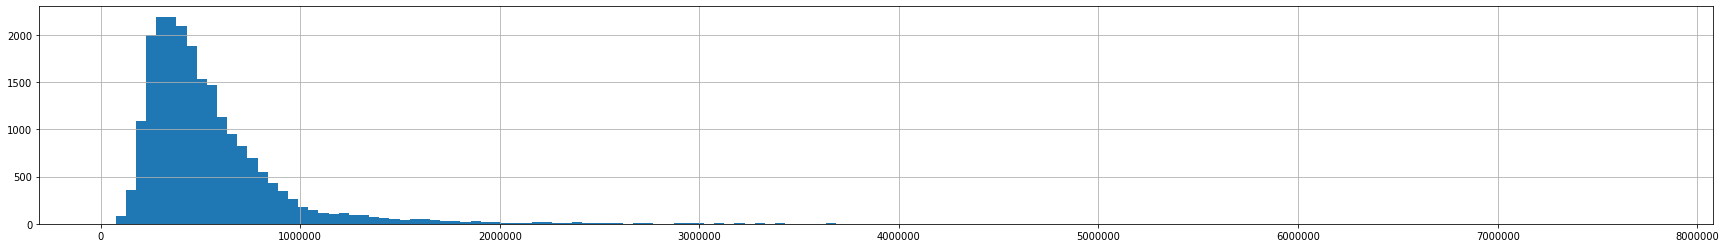

In [363]:
kc_house_data.price.hist(figsize = (30,4), bins=150)

### ==> seems like lognormal (sqewed) !

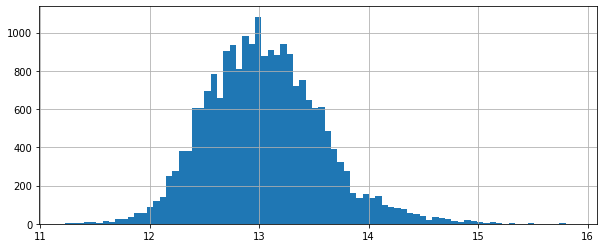

In [364]:
log_price = np.log(kc_house_data.price)
log_price.hist(figsize = (10,4), bins=80)

## Feature engineering: hence, we will use log(price) instead price in the price column:

In [0]:
kc_house_data.rename({'price': 'log_price'}, inplace=True, axis=1)
kc_house_data.log_price = log_price

# Removing outliers:

only +/- 3 std deviation sample range will be retained:

In [366]:
 std = kc_house_data['log_price'].std()
 ave = kc_house_data['log_price'].mean()
 kc_house_data = kc_house_data.loc[kc_house_data['log_price'].between(ave-3*std, ave+3*std)]
 kc_house_data.shape
    

(21443, 17)

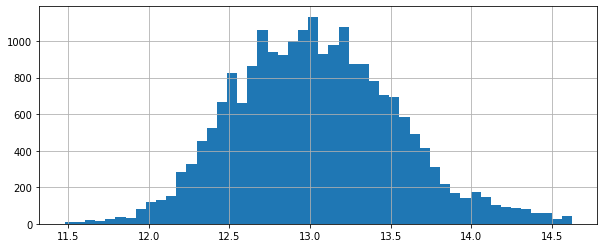

In [367]:
log_price1 = kc_house_data.log_price
log_price1.hist(figsize = (10,4), bins=50)

## sns Pair plot:

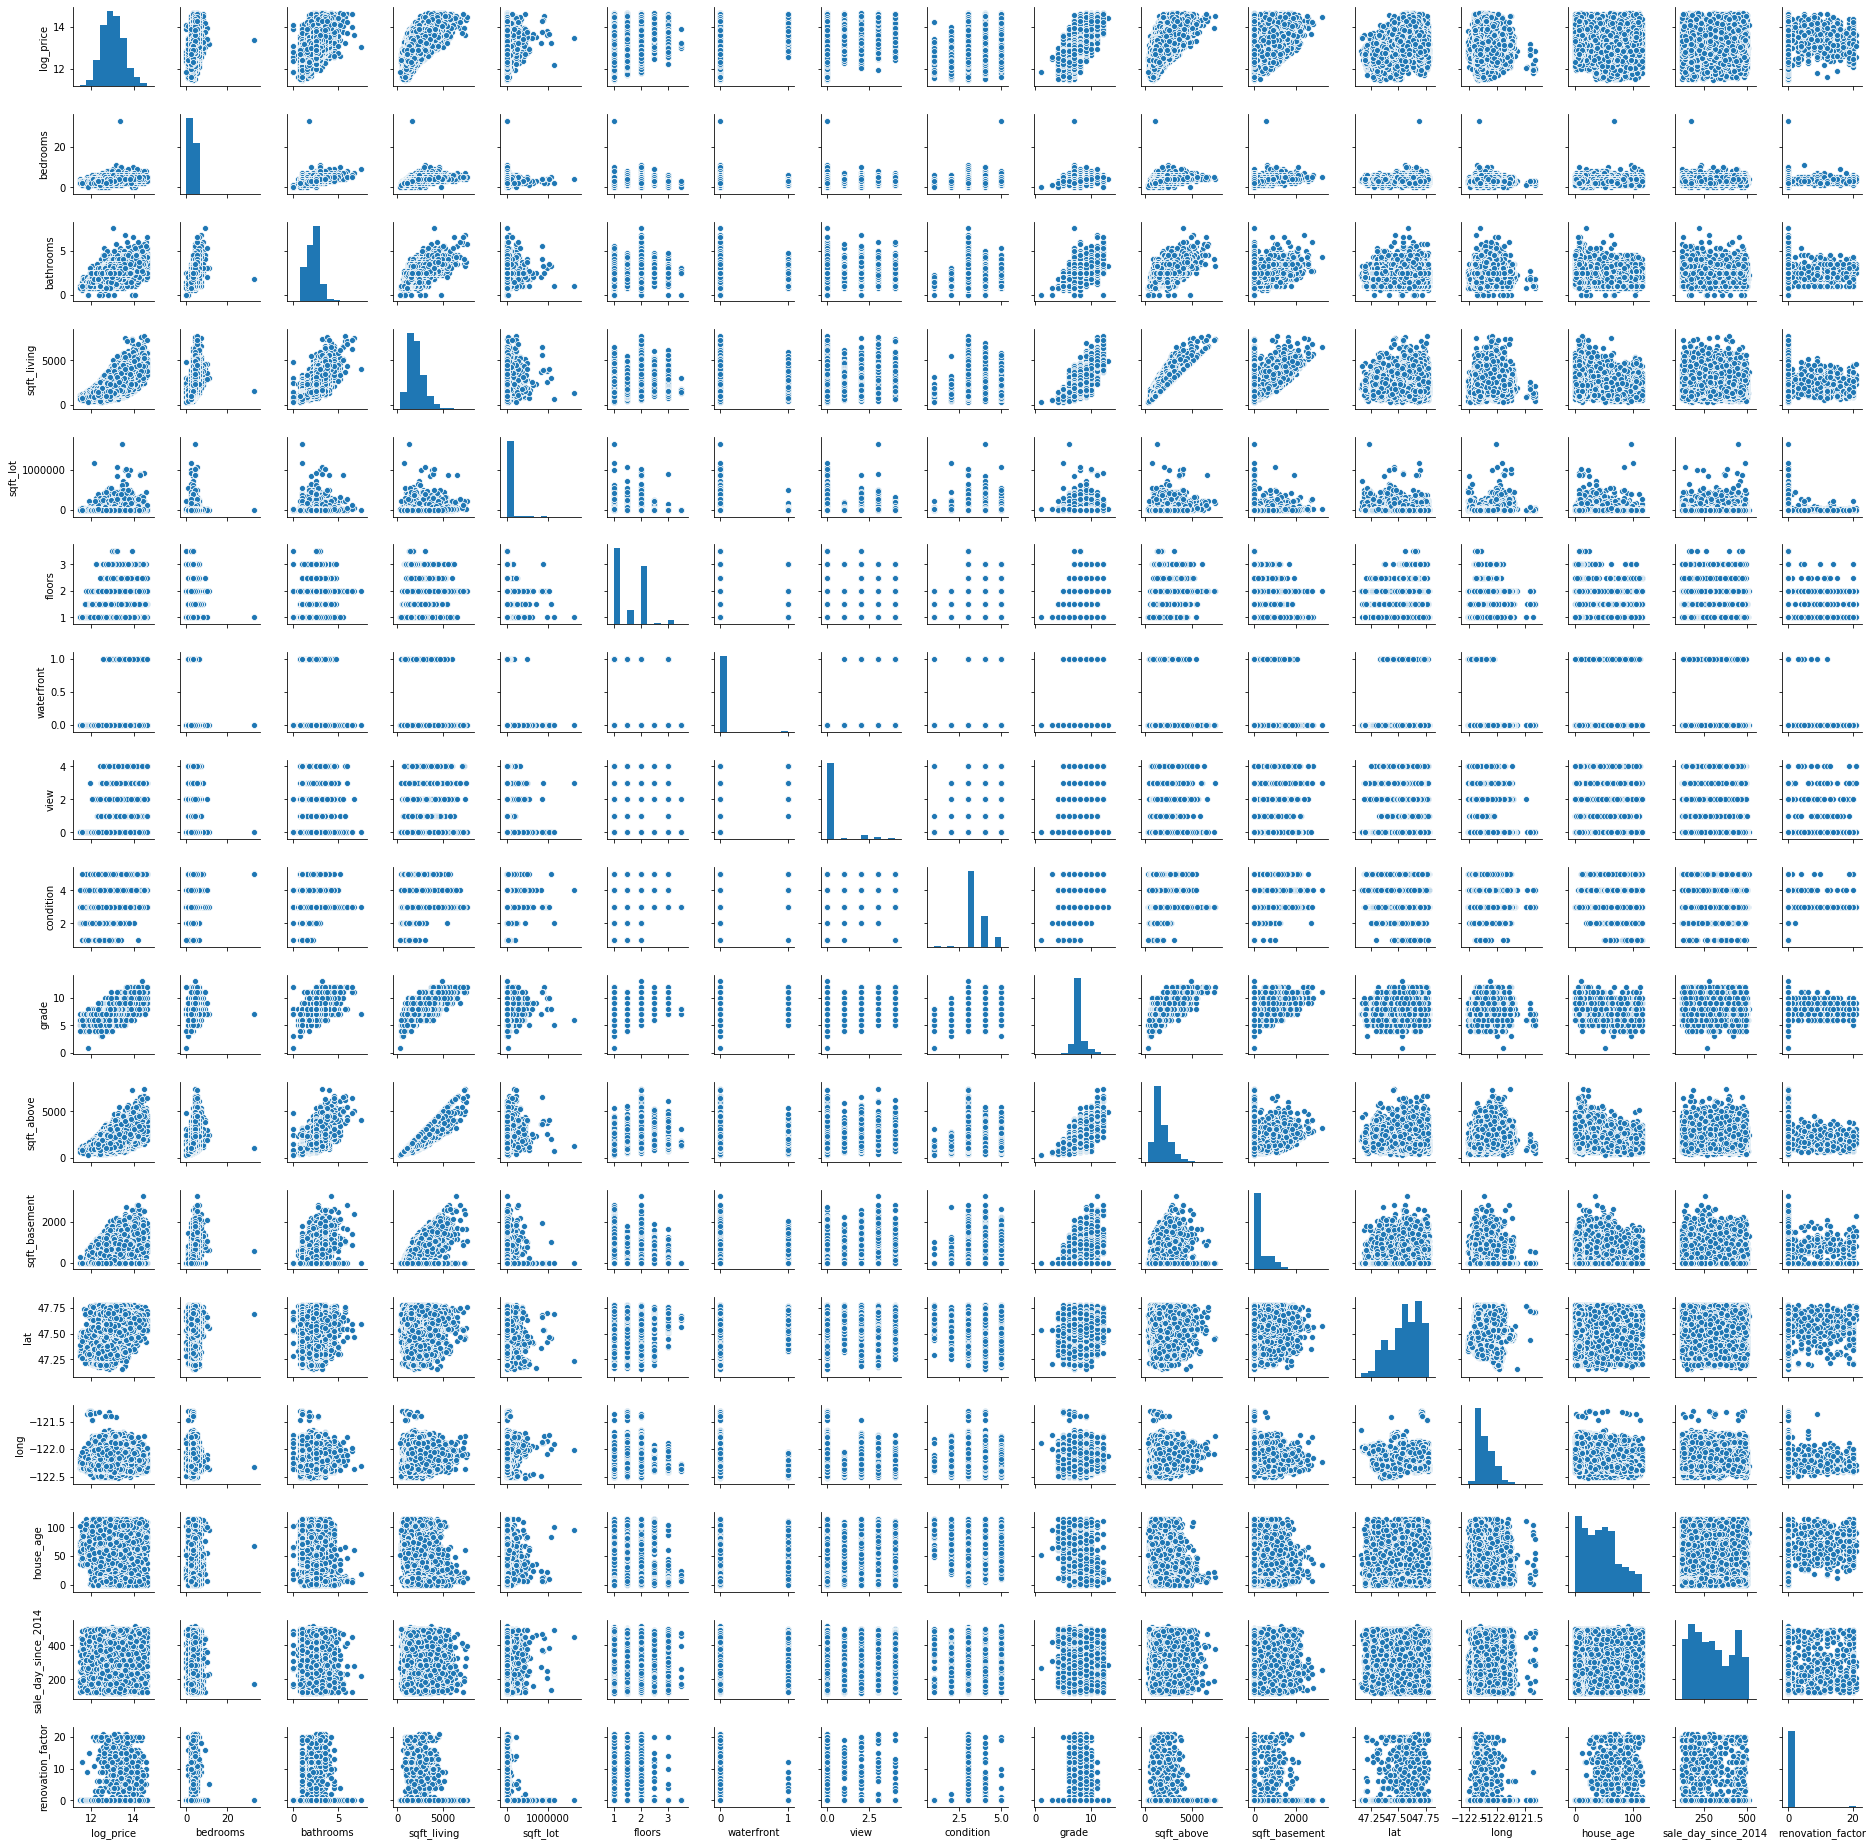

In [368]:
sns.pairplot(kc_house_data, height=1.5)

### correlation matrix:

In [369]:
kc_house_data.corr()

,log_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,house_age,sale_day_since_2014,renovation_factor
log_price,1.000000,0.329098,0.526001,0.672305,0.100243,0.307691,0.120538,0.313505,0.036608,0.683951,0.575859,0.290643,0.459113,0.055888,-0.078375,-0.005978,0.085271
bedrooms,0.329098,1.000000,0.508828,0.578324,0.029847,0.168823,-0.023456,0.065382,0.025792,0.344359,0.470544,0.295802,-0.013971,0.132664,-0.155073,-0.016262,0.031185
bathrooms,0.526001,0.508828,1.000000,0.742842,0.085441,0.503170,0.025750,0.158227,-0.130496,0.650638,0.670212,0.258526,0.016524,0.232218,-0.517705,-0.034587,0.055966
sqft_living,0.672305,0.578324,0.742842,1.000000,0.174769,0.354574,0.044977,0.249215,-0.064221,0.751297,0.869135,0.409077,0.043261,0.257881,-0.332934,-0.035173,0.036621
sqft_lot,0.100243,0.029847,0.085441,0.174769,1.000000,-0.006445,0.019323,0.073340,-0.008626,0.113364,0.184501,0.011341,-0.086576,0.229579,-0.052871,0.006744,-0.010712
floors,0.307691,0.168823,0.503170,0.354574,-0.006445,1.000000,0.014778,0.018894,-0.268239,0.459101,0.528517,-0.261492,0.047014,0.127800,-0.494160,-0.021725,-0.003531
waterfront,0.120538,-0.023456,0.025750,0.044977,0.019323,0.014778,1.000000,0.363120,0.018168,0.038218,0.027849,0.039141,-0.025156,-0.051109,0.035107,0.005044,0.007775
view,0.313505,0.065382,0.158227,0.249215,0.073340,0.018894,0.363120,1.000000,0.046275,0.221081,0.133280,0.255678,-0.001589,-0.079535,0.059236,-0.000561,0.036340
condition,0.036608,0.025792,-0.130496,-0.064221,-0.008626,-0.268239,0.018168,0.046275,1.000000,-0.152633,-0.166315,0.177601,-0.015772,-0.106196,0.361182,-0.051562,-0.077526
grade,0.683951,0.344359,0.650638,0.751297,0.113364,0.459101,0.038218,0.221081,-0.152633,1.000000,0.745160,0.137262,0.107592,0.208209,-0.457785,-0.041548,0.018886


#### correlation heat map:

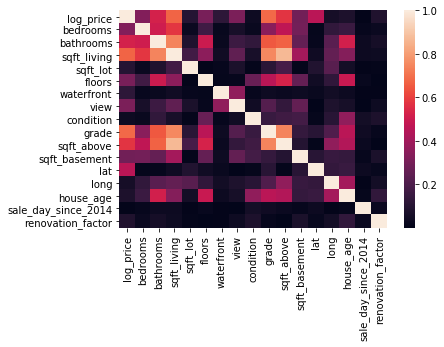

In [370]:
sns.heatmap(kc_house_data.corr().abs())

In [371]:
kc_house_data.corr()['log_price'].sort_values(ascending = False)

log_price              1.000000
grade                  0.683951
sqft_living            0.672305
sqft_above             0.575859
bathrooms              0.526001
lat                    0.459113
bedrooms               0.329098
view                   0.313505
floors                 0.307691
sqft_basement          0.290643
waterfront             0.120538
sqft_lot               0.100243
renovation_factor      0.085271
long                   0.055888
condition              0.036608
sale_day_since_2014   -0.005978
house_age             -0.078375
Name: log_price, dtype: float64

Interesting findings:
* Weakest correlation to house age ! (even slightly negative !)
* Much more stronger correlation to lattitude than to longitude ! (north is costly)


In [372]:
kc_house_data.head()

,log_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,house_age,sale_day_since_2014,renovation_factor
0,12.309982,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,47.5112,-122.257,59,285,0
1,13.195614,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,47.7210,-122.319,63,342,0
2,12.100712,2,1.00,770,10000,1.0,0,0,3,6,770,0,47.7379,-122.233,82,420,0
3,13.311329,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,47.5208,-122.393,49,342,0
4,13.142166,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,47.6168,-122.045,28,413,0


## Splitting the data

In [0]:
y = kc_house_data.log_price
X = kc_house_data.drop('log_price', axis=1)

In [0]:
X_train, X_test, y_train, y_test = split(X, y, random_state=314159)

In [375]:
X_train.head(200)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,house_age,sale_day_since_2014,renovation_factor
13315,3,2.50,2040,11211,2.0,0,0,3,8,2040,0,47.4867,-122.223,15,462,0
3830,4,1.75,1640,13566,1.0,0,0,4,7,1120,520,47.7423,-122.099,38,401,0
8146,4,3.50,3380,11270,2.0,0,1,3,9,2160,1220,47.6124,-122.060,8,386,0
20516,2,2.50,1280,819,2.0,0,0,3,8,1060,220,47.6905,-122.364,8,222,0
20825,3,2.50,2420,4725,2.0,0,0,3,8,2420,0,47.3710,-122.018,0,260,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10320,4,1.00,1760,8906,1.0,0,0,3,7,1230,530,47.4288,-122.198,49,415,0
20561,4,2.50,2714,12558,2.0,0,0,3,9,2714,0,47.3522,-122.201,0,320,0
3671,3,2.00,2420,208652,1.5,0,0,3,8,2420,0,47.3666,-121.978,9,203,0
13493,4,2.50,3480,6315,2.0,0,0,3,9,2360,1120,47.6841,-122.161,14,247,0


# Linear regression

## Fitting the model

In [0]:
lin_model = LinearRegression().fit(X_train, y_train)

We inspect the model...

In [377]:
list(zip(X_train.columns, lin_model.coef_))

[('bedrooms', -0.013045537915681743),
 ('bathrooms', 0.06036330273357834),
 ('sqft_living', 0.00012092494920173599),
 ('sqft_lot', 3.374441631884273e-07),
 ('floors', 0.06509397713474957),
 ('waterfront', 0.34511755136924605),
 ('view', 0.06704286293062069),
 ('condition', 0.06533700277016599),
 ('grade', 0.17558995197007068),
 ('sqft_above', 5.9852395088832305e-05),
 ('sqft_basement', 6.10725539669163e-05),
 ('lat', 1.3536373467268972),
 ('long', 0.04454437744835227),
 ('house_age', 0.003314037042903254),
 ('sale_day_since_2014', 0.00016505051163259553),
 ('renovation_factor', 0.008591286332035384)]

## Predicting with the model

In [0]:
y_train_pred = lin_model.predict(X_train)

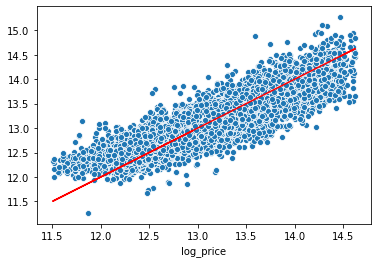

In [379]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

score of the model:

In [380]:
mse(y_train, y_train_pred)**0.5

0.2515015774894894

In [381]:
mse(np.exp(y_train), np.exp(y_train_pred))**0.5

167340.68180526874

### The state in terms of real prices (not log):

In [382]:
df_comp = pd.DataFrame({'log_y_train_pred':y_train_pred, 'exp_y_train_pred': np.exp(y_train_pred), 'log_y_train':y_train, 'exp_y_train': np.exp(y_train)})
df_comp['d_log_train_pred'] = (df_comp['log_y_train_pred'] - df_comp['log_y_train'])**2
df_comp['d_exp_train_pred'] = (df_comp['exp_y_train_pred'] - df_comp['exp_y_train'])**2
df_comp

,log_y_train_pred,exp_y_train_pred,log_y_train,exp_y_train,d_log_train_pred,d_exp_train_pred
13315,12.943369,4.180555e+05,12.940842,417000.0,0.000006,1.113999e+06
3830,13.056491,4.681250e+05,12.934225,414250.0,0.014949,2.902516e+09
8146,13.618741,8.213799e+05,13.670485,865000.0,0.002677,1.902717e+09
20516,13.022566,4.525104e+05,12.675920,319950.0,0.120163,1.757226e+10
20825,12.779341,3.548112e+05,12.821112,369946.0,0.001745,2.290620e+08
...,...,...,...,...,...,...
1466,13.071145,4.750354e+05,12.791078,359000.0,0.078437,1.346421e+10
3682,13.050141,4.651621e+05,12.971540,430000.0,0.006178,1.236376e+09
10661,12.548777,2.817503e+05,12.092344,178500.0,0.208331,1.066063e+10
16499,12.852045,3.815683e+05,12.909046,403950.0,0.003249,5.009401e+08


In [383]:
(df_comp['d_exp_train_pred'].mean())**0.5

167340.68180526895

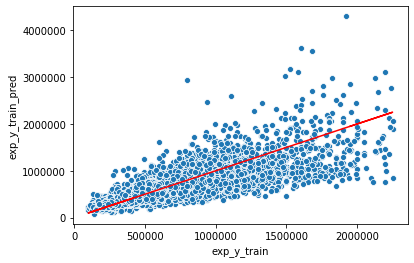

In [384]:
bx = sns.scatterplot(x=df_comp.exp_y_train, y=df_comp.exp_y_train_pred)
bx.plot(df_comp.exp_y_train, df_comp.exp_y_train, 'r')

score of the model

### Validating the model

Let's see how does the model work for the test data...

In [0]:
y_test_pred = lin_model.predict(X_test)

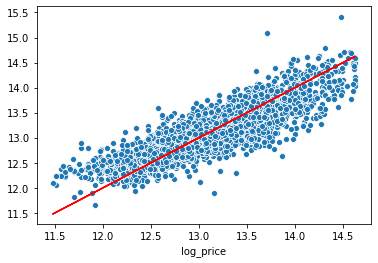

In [388]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [389]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.2549927710454699

RMSE(train) = 0.2515015774894894

RMSE(test) = 0.2549927710454699 ==>  **the model is valid!** 










# Regression by Decision Tree

### Fit the model

In [0]:
dt_model = DecisionTreeRegressor(min_samples_split=0.01, min_impurity_split=0.01)

#dt_model = DecisionTreeRegressor(min_samples_split=0.01, min_impurity_split=0.09, max_depth=100, min_samples_leaf=50, max_leaf_nodes=50, min_impurity_decrease=0.0001)

In [391]:
dt_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=0.01,
                      min_samples_leaf=1, min_samples_split=0.01,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

### Inspect the model

In [0]:
def visualize_tree(model, md=5):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

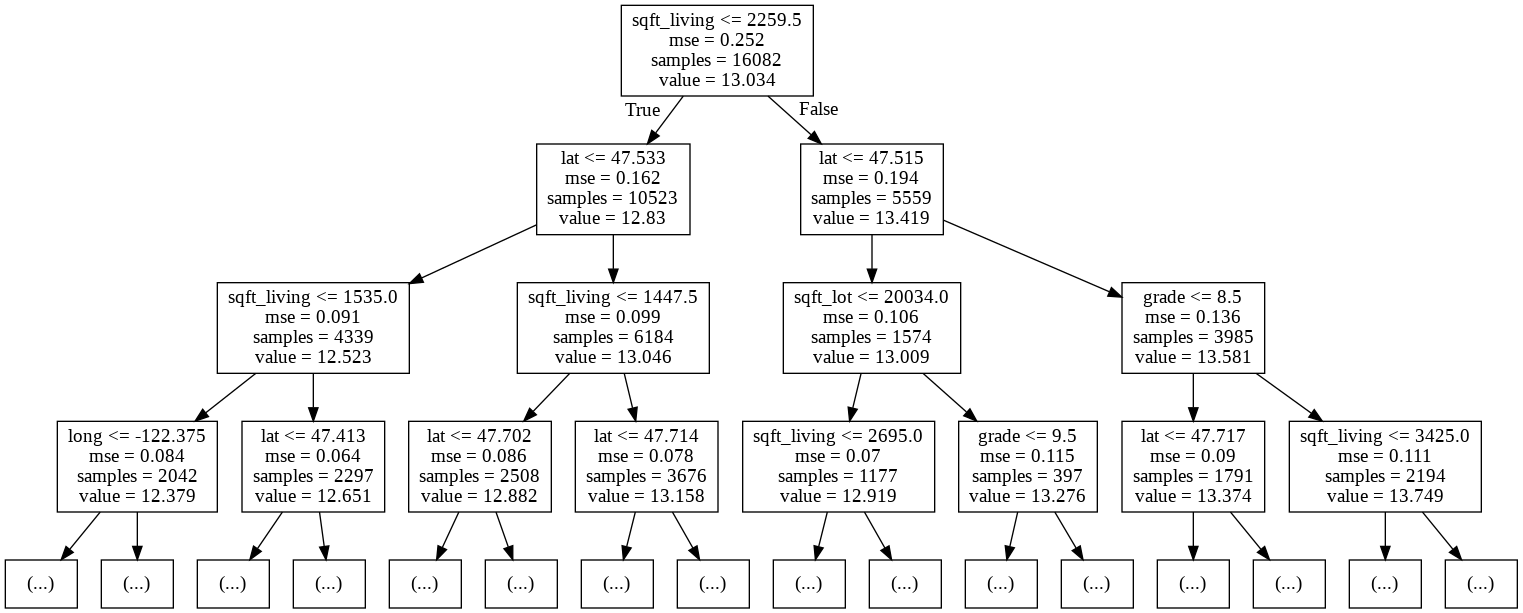

In [393]:
visualize_tree(dt_model, md=3)

In [0]:
#print_dot_text(dt_model)

### Predicting with the model

In [0]:
y_train_pred = dt_model.predict(X_train)

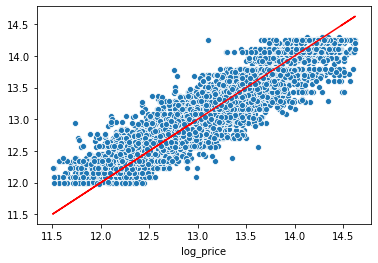

In [395]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [396]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.19412811595780882

In [397]:
mse(np.exp(y_train), np.exp(y_train_pred))**0.5

126726.30130702135

In [398]:
df_comp1 = pd.DataFrame({'log_y_train_pred':y_train_pred, 'exp_y_train_pred': np.exp(y_train_pred), 'log_y_train':y_train, 'exp_y_train': np.exp(y_train)})
df_comp1['d_log_train_pred'] = (df_comp1['log_y_train_pred'] - df_comp1['log_y_train'])**2
df_comp1['d_exp_train_pred'] = (df_comp1['exp_y_train_pred'] - df_comp1['exp_y_train'])**2
df_comp1

,log_y_train_pred,exp_y_train_pred,log_y_train,exp_y_train,d_log_train_pred,d_exp_train_pred
13315,12.845154,3.789481e+05,12.940842,417000.0,0.009156,1.447949e+09
3830,12.793791,3.599755e+05,12.934225,414250.0,0.019722,2.945721e+09
8146,13.610049,8.142715e+05,13.670485,865000.0,0.003652,2.573380e+09
20516,12.936909,4.153634e+05,12.675920,319950.0,0.068115,9.103717e+09
20825,12.805171,3.640953e+05,12.821112,369946.0,0.000254,3.423124e+07
...,...,...,...,...,...,...
1466,13.078504,4.785442e+05,12.791078,359000.0,0.082614,1.429081e+10
3682,13.080838,4.796623e+05,12.971540,430000.0,0.011946,2.466342e+09
10661,12.150125,1.891176e+05,12.092344,178500.0,0.003339,1.127344e+08
16499,12.765836,3.500518e+05,12.909046,403950.0,0.020509,2.905020e+09


In [399]:
(df_comp1['d_exp_train_pred'].mean())**0.5

126726.30130702161

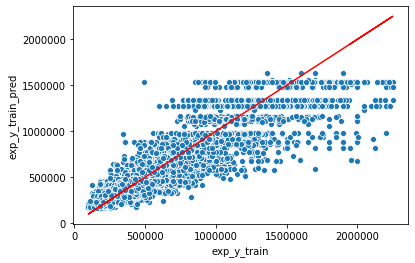

In [400]:
bx = sns.scatterplot(x=df_comp1.exp_y_train, y=df_comp1.exp_y_train_pred)
bx.plot(df_comp1.exp_y_train, df_comp1.exp_y_train, 'r')

### Validating the model

In [0]:
y_test_pred = dt_model.predict(X_test)

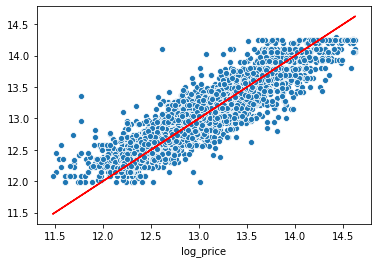

In [402]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [403]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.20939690304393258

MSE(train): 0.19412811595780882

MSE(test): 0.20939690304393258

The model is valid!

## Possible tuning of hyper parameters:

In [0]:
l_max_depth = [4, 6, 8, 10, 20, 30, 40]
l_min_samples_leaf = [50, 100, 150, 200, 250, 300]
l_min_impurity_decrease = [0, 0.001, 0.002, 0.005, 0.008]

In [0]:
from itertools import product

In [0]:
scores = []
for i, (md, msl, mid) in enumerate(product(l_max_depth, l_min_samples_leaf, l_min_impurity_decrease)):
    dt_model = DecisionTreeRegressor(max_depth=md, min_samples_leaf=msl, min_impurity_decrease=mid)
    dt_model.fit(X_train, y_train)
    y_train_pred = dt_model.predict(X_train)
    train_score = mse(y_train, y_train_pred)**0.5
    y_test_pred = dt_model.predict(X_test)
    test_score = mse(y_test, y_test_pred)**0.5
    scores.append((md, msl, mid, train_score, test_score))

In [407]:
sorted(scores, key=lambda x: x[3], reverse=False)

[(20, 50, 0, 0.19749269474707837, 0.21088890695169374),
 (40, 50, 0, 0.19749269474707837, 0.2108889069516937),
 (30, 50, 0, 0.1974926947470784, 0.21088890695169377),
 (10, 50, 0, 0.19984695403863176, 0.21172596342793254),
 (8, 50, 0, 0.20795226731140617, 0.2174322370999508),
 (20, 100, 0, 0.21267779955341423, 0.22244255625307321),
 (30, 100, 0, 0.21267779955341423, 0.22244255625307327),
 (40, 100, 0, 0.21267779955341423, 0.22244255625307313),
 (10, 100, 0, 0.21301846116446815, 0.22271944206849517),
 (8, 100, 0, 0.21651373768881535, 0.22530487443743974),
 (20, 150, 0, 0.2222782396923099, 0.23042178448654962),
 (30, 150, 0, 0.2222782396923099, 0.23042178448654962),
 (40, 150, 0, 0.2222782396923099, 0.23042178448654949),
 (10, 150, 0, 0.22240717470866034, 0.23040263073632902),
 (8, 150, 0, 0.22446760436237825, 0.23217904214350654),
 (6, 50, 0, 0.2308816564038034, 0.23640258953325843),
 (10, 200, 0, 0.2319526055746584, 0.23729302454759768),
 (20, 200, 0, 0.2319526055746584, 0.2372930245475

## No substantial improvement attained !

# Regression by K-Nearest Neighbors method:

## First model

In [0]:
knn_model_1 = KNeighborsRegressor(n_neighbors=4).fit(X_train, y_train)

In [0]:
y_train_pred = knn_model_1.predict(X_train)

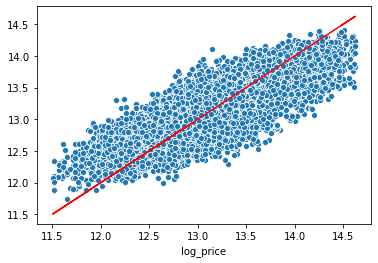

In [410]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [411]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.2942440702105664

### Validating the model

Let's see how does the model work for the test data...

In [0]:
y_test_pred = knn_model_1.predict(X_test)

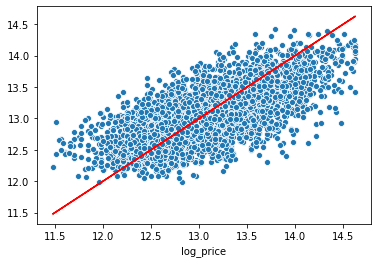

In [413]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [414]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.38509410410025646

## Scaling the data

In [0]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

In [416]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,house_age,sale_day_since_2014,renovation_factor
13315,3,2.50,2040,11211,2.0,0,0,3,8,2040,0,47.4867,-122.223,15,462,0
3830,4,1.75,1640,13566,1.0,0,0,4,7,1120,520,47.7423,-122.099,38,401,0
8146,4,3.50,3380,11270,2.0,0,1,3,9,2160,1220,47.6124,-122.060,8,386,0
20516,2,2.50,1280,819,2.0,0,0,3,8,1060,220,47.6905,-122.364,8,222,0
20825,3,2.50,2420,4725,2.0,0,0,3,8,2420,0,47.3710,-122.018,0,260,0


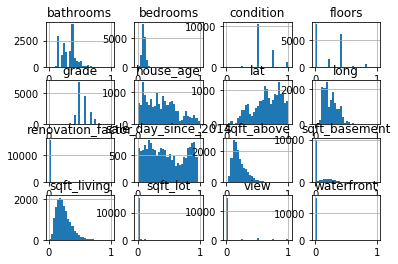

In [417]:
my_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
ax = X_train_scaled.hist(bins=30)

## Second model (after scaling)

In [0]:
knn_model_2 = KNeighborsRegressor().fit(X_train_scaled, y_train)

In [0]:
y_train_pred = knn_model_2.predict(X_train_scaled)

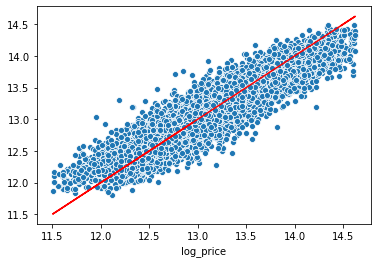

In [420]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [421]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.18217240781114816

### Validating the model

In [0]:
X_test_scaled = my_scaler.transform(X_test)

In [0]:
y_test_pred = knn_model_2.predict(X_test_scaled)

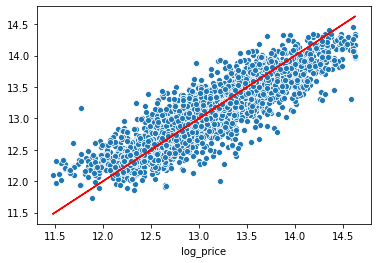

In [424]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [425]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.2276790391718306